# Performance Predictor (PP) test drift

Test drift
- Change logs by percentage of similarity to an example. e.g. higher similarity of logs to less similarity.

In this notebook, we will do the following
- Start with the WebOfScience dataset
  - Use the 90 classes with the highest class accuracy size
    - 90 classes deteremined in notebook:
      - 'WebOfScience - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'
  - Split the dataset into 2.
    - Randomize the examples from 90 most accurate classes.
    - First example is the "split-utterance" example
    - Sort examples based on similarity/dissimilarity to "split-utterance"
    - Split remaining into 2 buckets, i.e. similarity to "split-utterance" example, 50% closest & 50% furthest
  - Drift runs
    - Generate Runs populating train/test & prod based on percentages from 2 buckets.
    - Run 1
      - Train/Test 90% from similar 10% dissimilar
      - Prod 10% from similar & 90% from dissimilar
    - Run 2 Train/Test 80%/20% and Prod 20%/80%
    - Run 3 Train/Test 70%/30% and Prod 30%/70%
    - Then continue changing similar and dissimilar percentages

#### Load workspace dataset

In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from examples.blackbox_metamodel.util import NotebookUtils
from examples.blackbox_metamodel.util import DatasetUtils

os.environ["PYTHONWARNINGS"] = 'ignore'

pd.options.display.max_colwidth = 100

%load_ext autoreload
%autoreload 2

# Increase the width of the notebook so that it is the width of the browser 
# which allows larger size for the dashboard
display(HTML('<style>.container { width:100% !important; }</style>'))

2022-08-27 01:01:20.141487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-27 01:01:20.141528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load the dataset

In [2]:
%%time
data_dir = '../../../data'
datasets_info = {k:{} for k in DatasetUtils.constants.keys()}
datasets_info = {'webofscience':{}}
datasets_info = {'clinc150':{}}
for k, v in datasets_info.items():
    x, y = DatasetUtils().load_dataset(data_dir, k)
    print(f'{k} x.shape = {x.shape}')
    print(f'{k} y.shape = {y.shape}')
    v['x'] = x
    v['y'] = y

clinc150 x.shape = (22500,)
clinc150 y.shape = (22500,)
CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 30.7 ms


#### Encode with USE encoder

In [3]:
%%time
for k, v in datasets_info.items():
    x_encoded = NotebookUtils().encode(v['x'], 
                                       DatasetUtils().get_encoded_file_name(data_dir, k))
    v['x_encoded'] = x_encoded
    print(f'{k} x_encoded.shape = {x_encoded.shape}')

clinc150 x_encoded.shape = (22500, 384)
CPU times: user 1.6 s, sys: 62 ms, total: 1.66 s
Wall time: 1.66 s


#### Determine subset datasetd for running experiment
- keep_intents list is generated in a separate notebook.

In [4]:
%%time
for k, v in datasets_info.items():
    x_sub, y_sub = NotebookUtils().subset_dataset(DatasetUtils().get_keep_intents(k), v['x_encoded'], v['y'])
    v['x_sub'] = x_sub
    v['y_sub'] = y_sub
    print(f'{k} x_sub.shape                 = {x_sub.shape}')
    print(f'{k} y_sub.shape                 = {y_sub.shape}')
    print(f'{k} len(np.unique(y_sub)).shape = {len(np.unique(y_sub))}')

clinc150 x_sub.shape                 = (13500, 384)
clinc150 y_sub.shape                 = (13500,)
clinc150 len(np.unique(y_sub)).shape = 90
CPU times: user 49.6 ms, sys: 5.78 ms, total: 55.4 ms
Wall time: 55.1 ms


#### Split to similar & dissimilar buckets
- Randomize the dataset
- First example is the "split-utterance" example
- Use cosine similarity to determine closeness to "split-utterance" example
- Split datset into similar and dissimilar buckets
  - in halves - 50% closest & 50% furthest to "split-utterance" example
  - in quarters - 25% closest and 25% furthest to "split-utterance" example

In [5]:
%%time
# Split indices into 2 halves
# 1st half is the dis-similar indices
# 2nd half is the similar indices
dis_count_half = int(len(y) / 2)
sim_count_half = len(y) - dis_count_half

# Split indices into quarters
# 1st half is the dis-similar indices
# 4th half is the similar indices
dis_count_quarter = int(len(y) / 4)
sim_count_quarter = dis_count_quarter

for k, v in datasets_info.items():
    x_split_utterance, y_split_utterance, x, y = NotebookUtils().get_split_utterance(v['x_sub'], v['y_sub'])
    v['x_split_utterance'] = x_split_utterance
    v['y_split_utterance'] = y_split_utterance
    print(f'{k} x_split_utterance.shape = {x_split_utterance.shape}')
    print(f'{k} y_split_utterance.shape = {y_split_utterance.shape}')

    # generate the similar and dissimilar X,y values for half and quarter splits
    for suffix, dis_count, sim_count in zip(['_half', '_quarter'],
                                            [dis_count_half, dis_count_quarter],
                                            [sim_count_half, sim_count_quarter],
                                           ):
        x_dissimilar, y_dissimilar, x_similar, y_similar = NotebookUtils().get_buckets(x_split_utterance, x, y, dis_count, sim_count)
        v[f'x_dissimilar{suffix}'] = x_dissimilar
        v[f'y_dissimilar{suffix}'] = y_dissimilar
        v[f'x_similar{suffix}'] = x_similar
        v[f'y_similar{suffix}'] = y_similar
        print(f'{k} {suffix} x_dissimilar.shape = {x_dissimilar.shape}')
        print(f'{k} {suffix} y_dissimilar.shape = {y_dissimilar.shape}')
        print(f'{k} {suffix} x_similar.shape = {x_similar.shape}')
        print(f'{k} {suffix} y_similar.shape = {y_similar.shape}')

clinc150 x_split_utterance.shape = (1, 384)
clinc150 y_split_utterance.shape = (1,)
clinc150 _half x_dissimilar.shape = (11250, 384)
clinc150 _half y_dissimilar.shape = (11250,)
clinc150 _half x_similar.shape = (11250, 384)
clinc150 _half y_similar.shape = (11250,)
clinc150 _quarter x_dissimilar.shape = (5625, 384)
clinc150 _quarter y_dissimilar.shape = (5625,)
clinc150 _quarter x_similar.shape = (5625, 384)
clinc150 _quarter y_similar.shape = (5625,)
CPU times: user 191 ms, sys: 182 ms, total: 374 ms
Wall time: 116 ms


#### Test drift
- Drift runs
  - Generate Runs populating train/test & prod based on percentages from 2 buckets.
  - Run 1
    - Train/Test 90% from similar 10% dissimilar
    - Prod 10% from similar & 90% from dissimilar
  - Run 2 Train/Test 80%/20% and Prod 20%/80%
  - Run 3 Train/Test 70%/30% and Prod 30%/70%
  - Then continue changing similar and dissimilar percentages

In [6]:
%%time
train_size = 4609
test_size = 1000
# train_size = round(4609/2)
# test_size = round(1000/2)
split_suffix = '_half'
split_suffix = '_quarter'

percent_sim_runs = [0.98, 0.96, 0.95, 0.94, 0.92, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.08, 0.06, 0.05, 0.04, 0.02]
# percent_sim_runs = [0.95, 0.9, 0.8, 0.5]
# percent_sim_runs = [0.95, 0.9]
# percent_sim_runs = [0.95]

for k, v in datasets_info.items():
    experiments = NotebookUtils().run_experiments(percent_sim_runs,
                                                  train_size,
                                                  test_size,
                                                  v['x_split_utterance'],
                                                  v['y_split_utterance'],
                                                  v[f'x_similar{split_suffix}'],
                                                  v[f'y_similar{split_suffix}'],
                                                  v[f'x_dissimilar{split_suffix}'],
                                                  v[f'y_dissimilar{split_suffix}'])
    v['experiments'] = experiments

0 dur=18.88 - svc_train
0 dur=11.37 - svc_train_pred
0 dur=2.69 - svc_test_pred
0 dur=0.00 - svc_split_pred
0 dur=15.20 - svc_prod_predict
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
0 dur=704.05 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy'

Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=642.49 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=23.40 - pp_train_accuracy  = 95.19%
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=7.18 - pp_test_accuracy  = 95.29%
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=0.09 - p

8 dur=24.75 - pp_train_accuracy  = 95.83%
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
8 dur=6.05 - pp_test_accuracy  = 93.13%
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
8 dur=0.02 - pp_split_accuracy  = 97.66%
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
8 dur=36.73 - pp_prod_accuracy  = 93.06%
9 dur=26.94 - svc_train
9 dur=14.23 - svc_train_pred
9 dur=3.11 - svc_test_pred
9 dur=0.00 - svc_split_pred
9 dur=20.39 - svc_prod_predict
Predictor typ

Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
12 dur=29.38 - pp_prod_accuracy  = 92.52%
13 dur=25.91 - svc_train
13 dur=11.41 - svc_train_pred
13 dur=2.50 - svc_test_pred
13 dur=0.00 - svc_split_pred
13 dur=14.94 - svc_prod_predict
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confiden

17 dur=24.47 - svc_prod_predict
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
17 dur=635.37 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_

#### Summarize results

,dataset,run,sim %,dis %,train size,n uniq y_train,n y_train sim,n y_train dis,y_train sim %,y_train dis %,svc train accuracy,pp train accuracy,test size,n uniq y_test,n y_test sim,n y_test dis,y_test sim %,y_test dis %,svc test accuracy,pp test accuracy,svc split accuracy,pp split accuracy,prod size,n uniq y_prod,n y_prod sim,n y_prod dis,y_prod sim %,y_prod dis %,svc prod accuracy,pp prod accuracy,TH,TL,FH,FL,AUC
0,clinc150,0,98%,2%,4609,90,4517,92,98%,2%,98.87%,96.15%,1002,90,982,20,98%,2%,93.41%,95.25%,100.00%,95.40%,5626,89,113,5513,2%,98%,75.86%,85.95%,46.00%,29.86%,4.16%,19.98%,78.07%
1,clinc150,1,96%,4%,4609,90,4425,184,96%,4%,98.96%,95.96%,1003,90,962,41,96%,4%,94.22%,94.32%,100.00%,97.27%,5625,89,225,5400,4%,96%,82.83%,90.14%,69.53%,13.30%,6.35%,10.83%,80.04%
2,clinc150,2,95%,5%,4609,90,4379,230,95%,5%,98.94%,95.08%,1000,90,950,50,95%,5%,93.60%,94.08%,100.00%,95.18%,5626,90,281,5345,5%,95%,84.06%,88.59%,67.13%,16.92%,6.56%,9.38%,76.15%
3,clinc150,3,94%,6%,4609,90,4332,277,94%,6%,99.00%,96.13%,1000,90,940,60,94%,6%,94.30%,94.56%,100.00%,94.68%,5626,90,338,5288,6%,94%,86.49%,90.10%,68.91%,17.58%,5.08%,8.43%,76.98%
4,clinc150,4,92%,8%,4609,90,4240,369,92%,8%,99.11%,95.19%,1000,90,920,80,92%,8%,94.00%,95.29%,100.00%,97.35%,5626,90,450,5176,8%,92%,88.43%,91.97%,72.00%,16.42%,4.37%,7.20%,79.28%
5,clinc150,5,90%,10%,4609,90,4148,461,90%,10%,99.18%,95.52%,1000,90,900,100,90%,10%,94.30%,94.71%,100.00%,95.96%,5627,90,563,5064,10%,90%,89.35%,92.37%,69.82%,19.53%,4.50%,6.15%,74.98%
6,clinc150,6,80%,20%,4609,90,3687,922,80%,20%,99.20%,95.79%,1000,90,800,200,80%,20%,93.90%,94.74%,100.00%,96.66%,5629,90,1126,4503,20%,80%,92.02%,90.94%,78.11%,13.91%,2.11%,5.86%,84.05%
7,clinc150,7,70%,30%,4609,90,3226,1383,70%,30%,99.26%,96.15%,1000,90,700,300,70%,30%,93.20%,93.40%,100.00%,95.94%,5631,90,1689,3942,30%,70%,93.15%,93.38%,83.82%,9.32%,2.50%,4.35%,83.64%
8,clinc150,8,60%,40%,4609,90,2765,1844,60%,40%,99.22%,95.83%,1000,90,600,400,60%,40%,93.00%,93.13%,100.00%,97.66%,5635,90,2254,3381,40%,60%,92.83%,93.06%,79.59%,13.24%,1.77%,5.39%,89.17%
9,clinc150,9,50%,50%,4609,90,2304,2305,50%,50%,99.20%,95.53%,1000,90,500,500,50%,50%,94.20%,93.92%,100.00%,96.42%,5640,90,2820,2820,50%,50%,92.89%,93.44%,82.87%,10.02%,2.70%,4.41%,86.65%


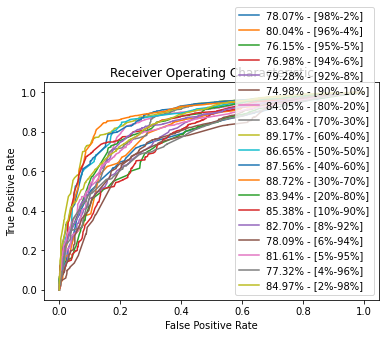

In [7]:
for k, v in datasets_info.items():
    display(HTML(f'<h2>{k}</h2>'))
    plt.figure()
    data = []
    for e in v['experiments']:
        y_true = [1 if y==p else 0 for y,p in zip(e['y_prod'], e['svc_prod_pred'])]
        fpr, tpr, thresholds = roc_curve(y_true, e['pp_prod_score'], pos_label=1)
        auc = roc_auc_score(y_true, e['pp_prod_score'])
        plt.plot(fpr, tpr, label=f'{auc:.2%} - [{e["sim%"]:.0%}-{e["dis%"]:.0%}]')
        acc_train, _, _, _, _ = NotebookUtils().check_correctness(e['y_train'],  e['svc_train_pred'],  e['pp_train_score'])
        acc_test, _, _, _, _ = NotebookUtils().check_correctness(e['y_test'],  e['svc_test_pred'],  e['pp_test_score'])
        acc_split, _, _, _, _ = NotebookUtils().check_correctness(e['y_split'],  e['svc_split_pred'],  e['pp_split_score'])
        acc, th, tl, fh, fl = NotebookUtils().check_correctness(e['y_prod'],  e['svc_prod_pred'],  e['pp_prod_score'])
        data.append({'dataset': k,
                     'run': e['run'],
                     'sim %': e['sim%'],
                     'dis %': e['dis%'],

                     'train size': len(e['y_train']),
                     'n uniq y_train': len(np.unique(e['y_train'])),
                     'n y_train sim': e['n_y_train_sim'],
                     'n y_train dis': e['n_y_train_dis'],
                     'y_train sim %': e['n_y_train_sim'] / len(e['y_train']),
                     'y_train dis %': e['n_y_train_dis'] / len(e['y_train']),
                     'svc train accuracy': acc_train,
                     'pp train accuracy': e['pp_train_accuracy'],

                     'test size': len(e['y_test']),
                     'n uniq y_test': len(np.unique(e['y_test'])),
                     'n y_test sim': e['n_y_test_sim'],
                     'n y_test dis': e['n_y_test_dis'],
                     'y_test sim %': e['n_y_test_sim'] / len(e['y_test']),
                     'y_test dis %': e['n_y_test_dis'] / len(e['y_test']),
                     'svc test accuracy': acc_test,
                     'pp test accuracy': e['pp_test_accuracy'],

                     'svc split accuracy': acc_split,
                     'pp split accuracy': e['pp_split_accuracy'],

                     'prod size': len(e['y_prod']),
                     'n uniq y_prod': len(np.unique(e['y_prod'])),
                     'n y_prod sim': e['n_y_prod_sim'],
                     'n y_prod dis': e['n_y_prod_dis'],
                     'y_prod sim %': e['n_y_prod_sim'] / len(e['y_prod']),
                     'y_prod dis %': e['n_y_prod_dis'] / len(e['y_prod']),
                     'svc prod accuracy': acc,
                     'pp prod accuracy': e['pp_prod_accuracy'],

                     'TH': th,
                     'TL': tl,
                     'FH': fh,
                     'FL': fl,
                     'AUC': auc,
        })

    pct_fmt = '{:,.2%}'.format
    fmt = {col: pct_fmt for col in ['svc train accuracy', 'pp train accuracy', 'svc test accuracy', 'pp test accuracy',
                                    'svc split accuracy', 'pp split accuracy', 'svc prod accuracy', 'pp prod accuracy',
                                    'TH', 'TL', 'FH', 'FL', 'AUC']}
    for col in ['sim %', 'dis %', 'y_train sim %', 'y_train dis %',
                'y_test sim %', 'y_test dis %', 'y_prod sim %', 'y_prod dis %']:
        fmt[col] = '{:,.0%}'.format

    display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

clinc150


,dataset,run,sim %,dis %,svc train accuracy,svc test accuracy,svc prod accuracy,pp prod accuracy,train size,test size,prod size,TH,TL,FH,FL,AUC
0,clinc150,0,0.98,0.02,98.87%,93.41%,75.86%,85.95%,4609,1002,5626,46.00%,29.86%,4.16%,19.98%,78.07%
1,clinc150,1,0.96,0.04,98.96%,94.22%,82.83%,90.14%,4609,1003,5625,69.53%,13.30%,6.35%,10.83%,80.04%
2,clinc150,2,0.95,0.05,98.94%,93.60%,84.06%,88.59%,4609,1000,5626,67.13%,16.92%,6.56%,9.38%,76.15%
3,clinc150,3,0.94,0.06,99.00%,94.30%,86.49%,90.10%,4609,1000,5626,68.91%,17.58%,5.08%,8.43%,76.98%
4,clinc150,4,0.92,0.08,99.11%,94.00%,88.43%,91.97%,4609,1000,5626,72.00%,16.42%,4.37%,7.20%,79.28%
5,clinc150,5,0.90,0.10,99.18%,94.30%,89.35%,92.37%,4609,1000,5627,69.82%,19.53%,4.50%,6.15%,74.98%
6,clinc150,6,0.80,0.20,99.20%,93.90%,92.02%,90.94%,4609,1000,5629,78.11%,13.91%,2.11%,5.86%,84.05%
7,clinc150,7,0.70,0.30,99.26%,93.20%,93.15%,93.38%,4609,1000,5631,83.82%,9.32%,2.50%,4.35%,83.64%
8,clinc150,8,0.60,0.40,99.22%,93.00%,92.83%,93.06%,4609,1000,5635,79.59%,13.24%,1.77%,5.39%,89.17%
9,clinc150,9,0.50,0.50,99.20%,94.20%,92.89%,93.44%,4609,1000,5640,82.87%,10.02%,2.70%,4.41%,86.65%


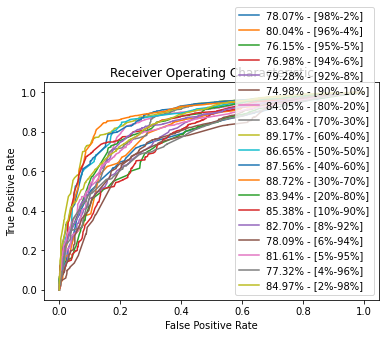

In [8]:
for k, v in datasets_info.items():
    display(HTML(f'<h2>{k}</h2>'))
    print(f'{k}')
    plt.figure()
    data = []
    for e in v['experiments']:
        y_true = [1 if y==p else 0 for y,p in zip(e['y_prod'], e['svc_prod_pred'])]
        fpr, tpr, thresholds = roc_curve(y_true, e['pp_prod_score'], pos_label=1)
        auc = roc_auc_score(y_true, e['pp_prod_score'])
        plt.plot(fpr, tpr, label=f'{auc:.2%} - [{e["sim%"]:.0%}-{e["dis%"]:.0%}]')
        acc_train, _, _, _, _ = NotebookUtils().check_correctness(e['y_train'],  e['svc_train_pred'],  e['pp_train_score'])
        acc_test, _, _, _, _ = NotebookUtils().check_correctness(e['y_test'],  e['svc_test_pred'],  e['pp_test_score'])
        acc_split, _, _, _, _ = NotebookUtils().check_correctness(e['y_split'],  e['svc_split_pred'],  e['pp_split_score'])
        acc, th, tl, fh, fl = NotebookUtils().check_correctness(e['y_prod'],  e['svc_prod_pred'],  e['pp_prod_score'])
        data.append({'dataset': k,
                     'run': e['run'],
                     'sim %': e['sim%'],
                     'dis %': e['dis%'],
                     'svc train accuracy': acc_train,
                     'svc test accuracy': acc_test,
                     'svc prod accuracy': acc,
                     'pp prod accuracy': e['pp_prod_accuracy'],
                     'train size': len(e['y_train']),
                     'test size': len(e['y_test']),
                     'prod size': len(e['y_prod']),
                     'TH': th,
                     'TL': tl,
                     'FH': fh,
                     'FL': fl,
                     'AUC': auc,
        })

    pct_fmt = '{:,.2%}'.format
    fmt = {col: pct_fmt for col in ['svc train accuracy', 'pp train accuracy',
                                    'svc test accuracy', 'pp test accuracy',
                                    'svc split accuracy', 'pp split accuracy',
                                    'svc prod accuracy', 'pp prod accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}
    display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [9]:
for k, v in datasets_info.items():
    data = []
    for e in v['experiments']:
        data.append({'dataset': k,
                     'run': e['run'],
                     'sim %': e['sim%'],
                     'dis %': e['dis%'],
                     'n train': len(np.unique(e['y_train'])),
                     'n test': len(np.unique(e['y_test'])),
                     'n prod': len(np.unique(e['y_prod'])),
        })
    display(HTML(pd.DataFrame(data).to_html()))

,dataset,run,sim %,dis %,n train,n test,n prod
0,clinc150,0,0.98,0.02,90,90,89
1,clinc150,1,0.96,0.04,90,90,89
2,clinc150,2,0.95,0.05,90,90,90
3,clinc150,3,0.94,0.06,90,90,90
4,clinc150,4,0.92,0.08,90,90,90
5,clinc150,5,0.90,0.10,90,90,90
6,clinc150,6,0.80,0.20,90,90,90
7,clinc150,7,0.70,0.30,90,90,90
8,clinc150,8,0.60,0.40,90,90,90
9,clinc150,9,0.50,0.50,90,90,90


In [10]:
for k, v in datasets_info.items():
    results_file = DatasetUtils().get_results_file_name(data_dir, k)
    df = pd.DataFrame(v['experiments'])
    df.to_parquet(results_file)

In [11]:
results = {}
for k, v in datasets_info.items():
    results_file = DatasetUtils().get_results_file_name(data_dir, k)
    df = pd.read_parquet(results_file)
    experiments = df.to_dict(orient='records')
    results[k] = {'experiments': experiments}

for k, v in results.items():
    data = []
    for e in v['experiments']:
        data.append({'dataset': k,
                     'run': e['run'],
                     'sim %': e['sim%'],
                     'dis %': e['dis%'],
                     'n train': len(np.unique(e['y_train'])),
                     'n test': len(np.unique(e['y_test'])),
                     'n prod': len(np.unique(e['y_prod'])),
        })
    display(HTML(pd.DataFrame(data).to_html()))

,dataset,run,sim %,dis %,n train,n test,n prod
0,clinc150,0,0.98,0.02,90,90,89
1,clinc150,1,0.96,0.04,90,90,89
2,clinc150,2,0.95,0.05,90,90,90
3,clinc150,3,0.94,0.06,90,90,90
4,clinc150,4,0.92,0.08,90,90,90
5,clinc150,5,0.90,0.10,90,90,90
6,clinc150,6,0.80,0.20,90,90,90
7,clinc150,7,0.70,0.30,90,90,90
8,clinc150,8,0.60,0.40,90,90,90
9,clinc150,9,0.50,0.50,90,90,90
